In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('styler.latex.hrules', True)
pd.set_option('styler.format.precision', 2) 

# Generic functions

In [55]:
def unhex_str(compressed_object : str):
    as_str = bytes.fromhex(compressed_object).decode('utf-8').replace('][', ' ').replace('[', '').replace(']', '')
    return [float(x) for x in as_str.split(' ')]

def plot_for_line(line : pd.core.series.Series, ax : matplotlib.axes._axes.Axes = None):
    if ax is None:
        fig, ax =  plt.subplots(1, 1, figsize=(8, 4), layout='constrained')
    ax.plot(line['realdata_uncompressed'], color='grey',  linestyle='-.',  alpha=0.4)
    ax.plot(line['predictold_uncompressed'])
    ax.plot(line['predictnew_uncompressed'])
    #plt.xlabel('Ticks')
    stable_str = '(stable)' if line['stable'] else '(unstable)'
    ax.set_title('n° ' + str(line['iteration']+3) + ' ' + stable_str)
    # +3 as there is no LSTM on first rounds [0:3]
    if line['metric'] == 'cpu_usage':
        ax.set_ylabel('Cores used')
    else:
        ax.set_ylabel('Memory used (MB)')

def plot_lstm_cpu(from_index : int = 0):
    from_index*=2
    if from_index%2 != 0:
        from_index = from_index+1
    to_index = from_index+(9*2)
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained')
    for ax, line in zip(axs.flat, list(range(from_index, to_index, 2))):
        plot_for_line(line=trace_df.iloc[line], ax=ax)
        
def plot_lstm_mem(from_index : int = 0):
    from_index*=2
    if from_index%2 != 1:
        from_index = from_index+1
    to_index = from_index+(9*2)
    
    fig, axs = plt.subplots(3, 3, figsize=(10, 6), layout='constrained')
    for ax, line in zip(axs.flat, list(range(from_index, to_index, 2))):
        plot_for_line(line=trace_df.iloc[line], ax=ax)

# Load traces

In [56]:
location = '/usr/local/src/scroogevm/dump-decrease/dump-lstm.csv' # Adapt the location

trace_df = pd.read_csv(location, index_col=False, delimiter='\t')

# Apply a 1% threshold (can be changed)
trace_df['threshold'] = trace_df['config'].apply(lambda config : config*0.01)

trace_df['stable'] = trace_df.apply(lambda row : True if row['gap'] < row['threshold'] else False, axis=1)
trace_df['realdata_uncompressed'] = trace_df['realdata'].apply(lambda row : unhex_str(row))
trace_df['predictold_uncompressed'] = trace_df['predictold'].apply(lambda row : unhex_str(row))
trace_df['predictnew_uncompressed'] = trace_df['predictnew'].apply(lambda row : unhex_str(row))

print("Reading of LSTM traces completed successfully!")

Reading of LSTM traces completed successfully!


# Build Graphs

Observed data can be seen in generated graphs from the blue color. Orange curve shows the model prediction on historical data. Green curve shows the model prediction on the latest data. Average mispredict from both prediction is retrieved to compute a delta. If a delta exceeds a threshold, the model is considered as unstable

Considered unstable, prediction mispredict delta : 4.91620989747595 >= 2.56 (threshold)


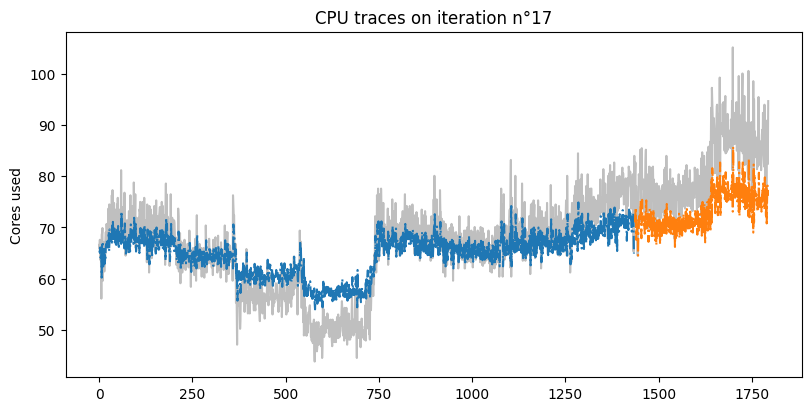

In [49]:
line_number = 32
plot_for_line(trace_df.iloc[line_number])
x = plt.title('CPU traces on iteration n°' + str(trace_df.iloc[line_number]['iteration']))
if trace_df.iloc[line_number]['stable']:
    print('Considered stable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '<', trace_df.iloc[line_number]['threshold'], '(threshold)')
else:
    print('Considered unstable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '>=', trace_df.iloc[line_number]['threshold'], '(threshold)')

Considered stable, prediction mispredict delta : 8400.58979390514 < 10565.14832 (threshold)


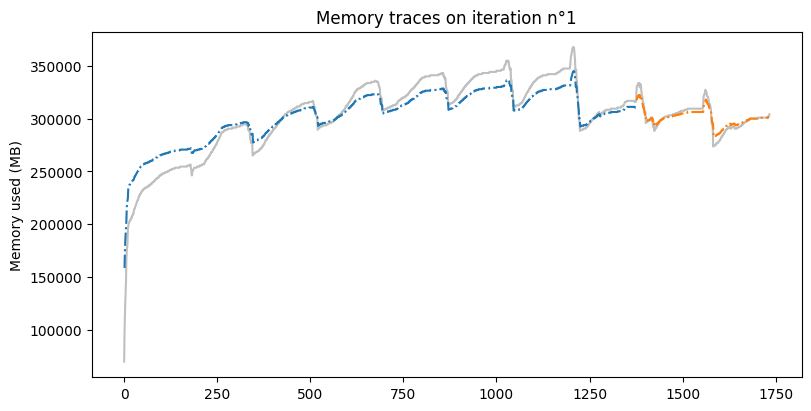

In [51]:
line_number = 1
plot_for_line(trace_df.iloc[line_number])
x = plt.title('Memory traces on iteration n°' + str(trace_df.iloc[line_number]['iteration']))
if trace_df.iloc[line_number]['stable']:
    print('Considered stable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '<', trace_df.iloc[line_number]['threshold'], '(threshold)')
else:
    print('Considered unstable, prediction mispredict delta :',trace_df.iloc[line_number]['gap'], '>=', trace_df.iloc[line_number]['threshold'], '(threshold)')

CPU traces on multiple iterations displayed:


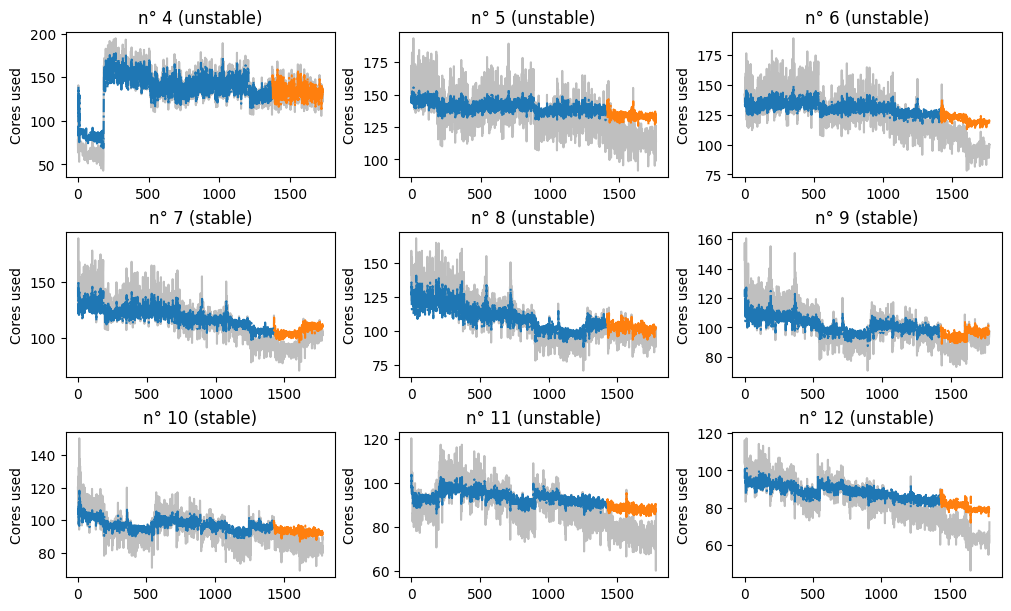

In [53]:
plot_lstm_cpu(from_index=0)
print('CPU traces on multiple iterations displayed:')

# Compare LSTM to naive approaches

In [8]:
from model.stability_assesser.stabilityassesseraveragethreshold import StabilityAssesserAverageThreshold
from model.stability_assesser.stabilityassesserpercentilethreshold import StabilityAssesserPercentileThreshold
from model.stability_assesser.stabilityassesserpvalue import StabilityAssesserPValue
from model.stability_assesser.stabilityassesserlstm import StabilityAssesserLstm

assesser_avg  = StabilityAssesserAverageThreshold()
assesser_per  = StabilityAssesserPercentileThreshold()
assesser_pval = StabilityAssesserPValue()
assesser_lstm = StabilityAssesserLstm()

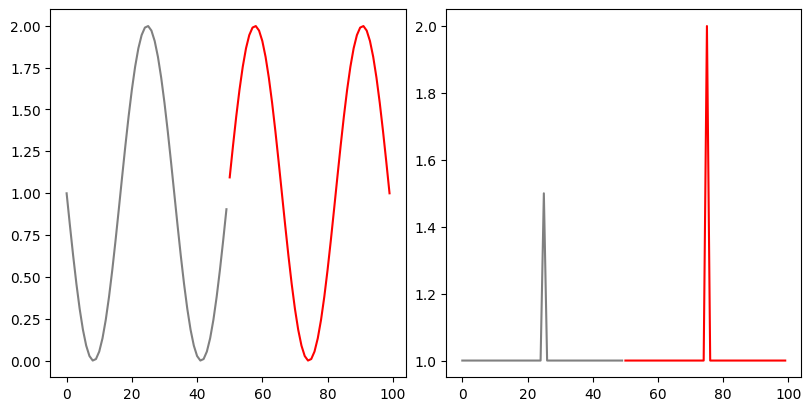

In [23]:
timestamp = list(range(0, 100))
mid_index = int(len(timestamp)/2)
dataset_list = list()

#Test case 1 : Sinus
test_case = dict()
wave = 3
values = np.sin(np.linspace(-np.pi*wave, np.pi*wave, 100))
min_val = np.abs(min(values))
values_positive = [value + min_val for value in values]
test_case['old_val']  = values_positive[:mid_index]
test_case['old_tmst'] = timestamp[:mid_index] 
test_case['new_val']  = values_positive[mid_index:]
test_case['new_tmst'] = timestamp[mid_index:]
dataset_list.append(test_case)

#Test case 2 : peak
test_case = dict()
values = [1 for x in range(len(timestamp))]
values[int(mid_index/2)] = 1.5
values[int(mid_index + (mid_index/2))] = 2
test_case['old_val']  = values[:mid_index]
test_case['old_tmst'] = timestamp[:mid_index] 
test_case['new_val']  = values[mid_index:]
test_case['new_tmst'] = timestamp[mid_index:]
dataset_list.append(test_case)

fig, axs = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
for ax, index in zip(axs.flat, list(range(2))):
    test_case = dataset_list[index]
    ax.plot(test_case['old_tmst'], test_case['old_val'], color='grey')
    ax.plot(test_case['new_tmst'], test_case['new_val'], color='red')

In [7]:
result = assesser_avg.assess(old_data=old_val, new_data=new_val, threshold=1)
print("According to StabilityAssesserAverageThreshold, result:", result)
result = assesser_per.assess(old_data=old_val, new_data=new_val, percentile=90, threshold=0.1)
print("According to StabilityAssesserPercentileThreshold, result:", result)
result = assesser_pval.assess(old_data=old_val, new_data=new_val, threshold=0.1)
print("According to StabilityAssesserPValue, result:", result)
result = assesser_lstm.assess(old_data=old_val, new_data=new_val, threshold=0.1)
print("According to StabilityAssesserLstm, result:", result)

According to StabilityAssesserAverageThreshold, result: True
According to StabilityAssesserPercentileThreshold, result: False
According to StabilityAssesserPValue, result: True
According to StabilityAssesserLstm, result: False


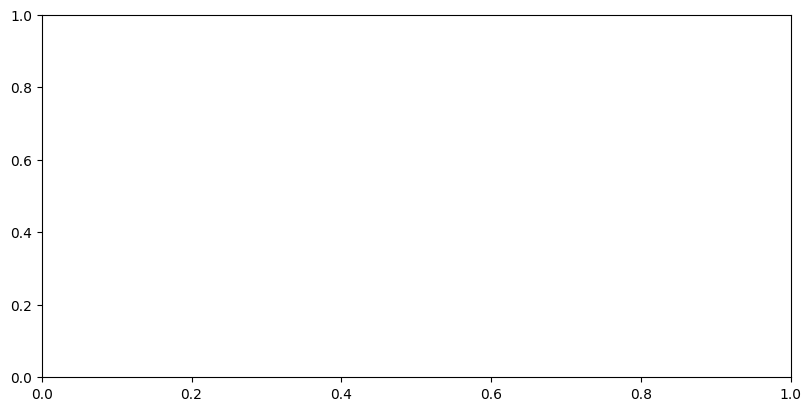

In [9]:
fig, ax =  plt.subplots(1, 1, figsize=(3, 4), layout='constrained')